In [1]:
from explore_hidden_states import collect_info, plot_umap, get_score_label, plot_socre_label, plot_line, plot_common_max_min
%matplotlib inline
from transformers import AutoConfig
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import torch
import sys
import copy
import os
import glob
import pickle

In [2]:
datalabels = {
        "emotion": ["sadness", "joy", "love", "anger", "fear"],  # , "surprise"
        "language": ['', 'en', 'ru', 'sl'],
        "math": ['original', 'think']
    }
dataset_dict = {
    'emotion': "dair-ai_emotion",
    "math": 'camel-ai_math',
    # 'paraphrase': 'embedding-data/WikiAnswers',
    'language': 'opus_wikipedia'
}
module_keys_m = {  # 'mlp': {"text": [], "label": [], "activation": []},
    # 'attn': {"text": [], "label": [], "activation": []},
    'hidden_states': {"text": [], "label": [], "activation": []}}

In [3]:
def get_info(model_name, key, key_):
    path = f'../get_activation/hiddenStates/{model_name}/{key}'
    module_keys = copy.deepcopy(module_keys_m)
    collect_info(path, module_keys)
    d = module_keys[key_]
    return module_keys, d

def get_data_pd(d, layer_id):
    activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
    # construct dataframe
    unit_num = activations.shape[-1]
    sentence_num = activations.shape[0]
    data_pd = pd.DataFrame(activations,
                 index=[f"sentence{i}" for i in range(sentence_num)],
                 columns=[f"unit{i}" for i in range(unit_num)])
    data_pd['label'] = d['label']
    return data_pd

In [4]:
layer_id = 22
model_name = 'gpt2-xl' # 'gpt2-large',  'gpt2-medium'
model_config = AutoConfig.from_pretrained(model_name)
key_ = 'hidden_states'


key = "math" # "emotion", "language"
label_list = datalabels[key]

dir_path = f'./result/activation/{key}/{model_name}/layer{layer_id}'

In [5]:
model_config

GPT2Config {
  "_name_or_path": "gpt2-xl",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1600,
  "n_head": 25,
  "n_inner": null,
  "n_layer": 48,
  "n_positions": 1024,
  "output_past": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.35.2",
  "use_cache": true,
  "vocab_size": 50257
}

In [6]:
module_keys, d = get_info(model_name, key, key_)
module_keys

{'hidden_states': {'text': ['Determine the number of solutions in $x$ of the congruence $64x\\equiv 2\\pmod {66}$ such that $0< x\\le 100$.',
   "Let's think step by step:January 1, 2000 was on a Saturday. On what day of the week was January 1, 1960?",
   "Let's think step by step:What integer $n$ satisfies $0\\le n<{101}$ and $$-314159\\equiv n\\pmod {101}~?$$",
   'How many integers from $-100$ to $100$ are congruent to $3 \\pmod{11}?$',
   'Find the positive base $b$ in which the equation $5 \\cdot 25_b = 137_b$ is valid.',
   'Find the remainder of $2^8$ when it is divided by 5.',
   'Remove the integers which are congruent to 3 (mod 7) from the following list of five integers, and sum the integers that remain. $$\n85 \\qquad 49,\\!479 \\qquad -67 \\qquad 12,\\!000,\\!003 \\qquad -3\n$$',
   'What integer $n$ satisfies $0\\le n<18$ and $$n\\equiv 142857\\pmod{18}~?$$',
   "Let's think step by step:How many integers from $-100$ to $100$ are congruent to $3 \\pmod{11}?$",
   'How man

In [7]:
data_pd = get_data_pd(d, layer_id)
data_pd.head()

unit0     unit1     unit2     unit3     unit4     unit5  \
sentence0 -1.882243  1.544727  0.413747  0.135211 -0.046870 -0.006617   
sentence1 -2.412832 -0.931005 -0.878404  0.347067 -1.409646 -0.955583   
sentence2 -1.705739  1.630538  0.345552  0.238269 -0.516685 -0.830879   
sentence3 -1.565117 -0.001630 -0.044582  0.257112  0.234085 -1.231339   
sentence4 -1.725174  2.918428  1.399868  0.522707 -0.857192 -0.249481   

              unit6     unit7     unit8     unit9  ...   unit1591  unit1592  \
sentence0  0.606922 -0.373355  1.036575 -1.025838  ... -34.587547 -1.128845   
sentence1  0.143585 -0.429361  1.117450 -0.525742  ... -66.667282 -3.698333   
sentence2  0.534933 -2.147709  0.705580 -0.696767  ... -33.278629 -1.672877   
sentence3 -0.414342 -2.013948  1.105382 -0.650019  ... -68.691628 -1.348434   
sentence4  0.857166  0.254816  2.460886 -1.562701  ... -66.832214 -1.665287   

           unit1593  unit1594  unit1595  unit1596  unit1597  unit1598  \
sentence0  2.042856 -1.993209 -0.952719  0.800326 -1.555764  0.502189   
sentence1  1.708465  0.063485 -0.572327 -1.108643 -1.530418 -0.654860   
sentence2  2.333622 -1.577386  0.183535  0.582438 -0.854281  0.213304   
sentence3  2.579164 -1.972438  0.813905  0.260814 -1.804355  0.799890   
sentence4  2.081517 -1.060122  0.156812  0.831520 -0.619086  0.831371   

           unit1599  label  
sentence0 -0.515436      0  
sentence1 -1.809463      1  
sentence2 -1.347755      1  
sentence3 -0.762998      0  
sentence4  1.019989      0  

[5 rows x 1601 columns]

# math

 ## draw score bar

In [8]:
print(model_config.n_layer, model_name,key_)
key = "math" # "emotion", "language", "math"
module_keys, d = get_info(model_name, key, key_)
datalabel = datalabels[key]

48 gpt2-xl hidden_states


In [9]:
top_k = 10
layer_id = 46
# draw score bar
text = d['text']
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
y_array = np.array(d['label'])

results, text_list = get_score_label(activations, y_array, text)
# title = f"{model_name}_{dataset_dict[key]}_layer{layer_id}"
dirs = f"{dir_path}/score_label"
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

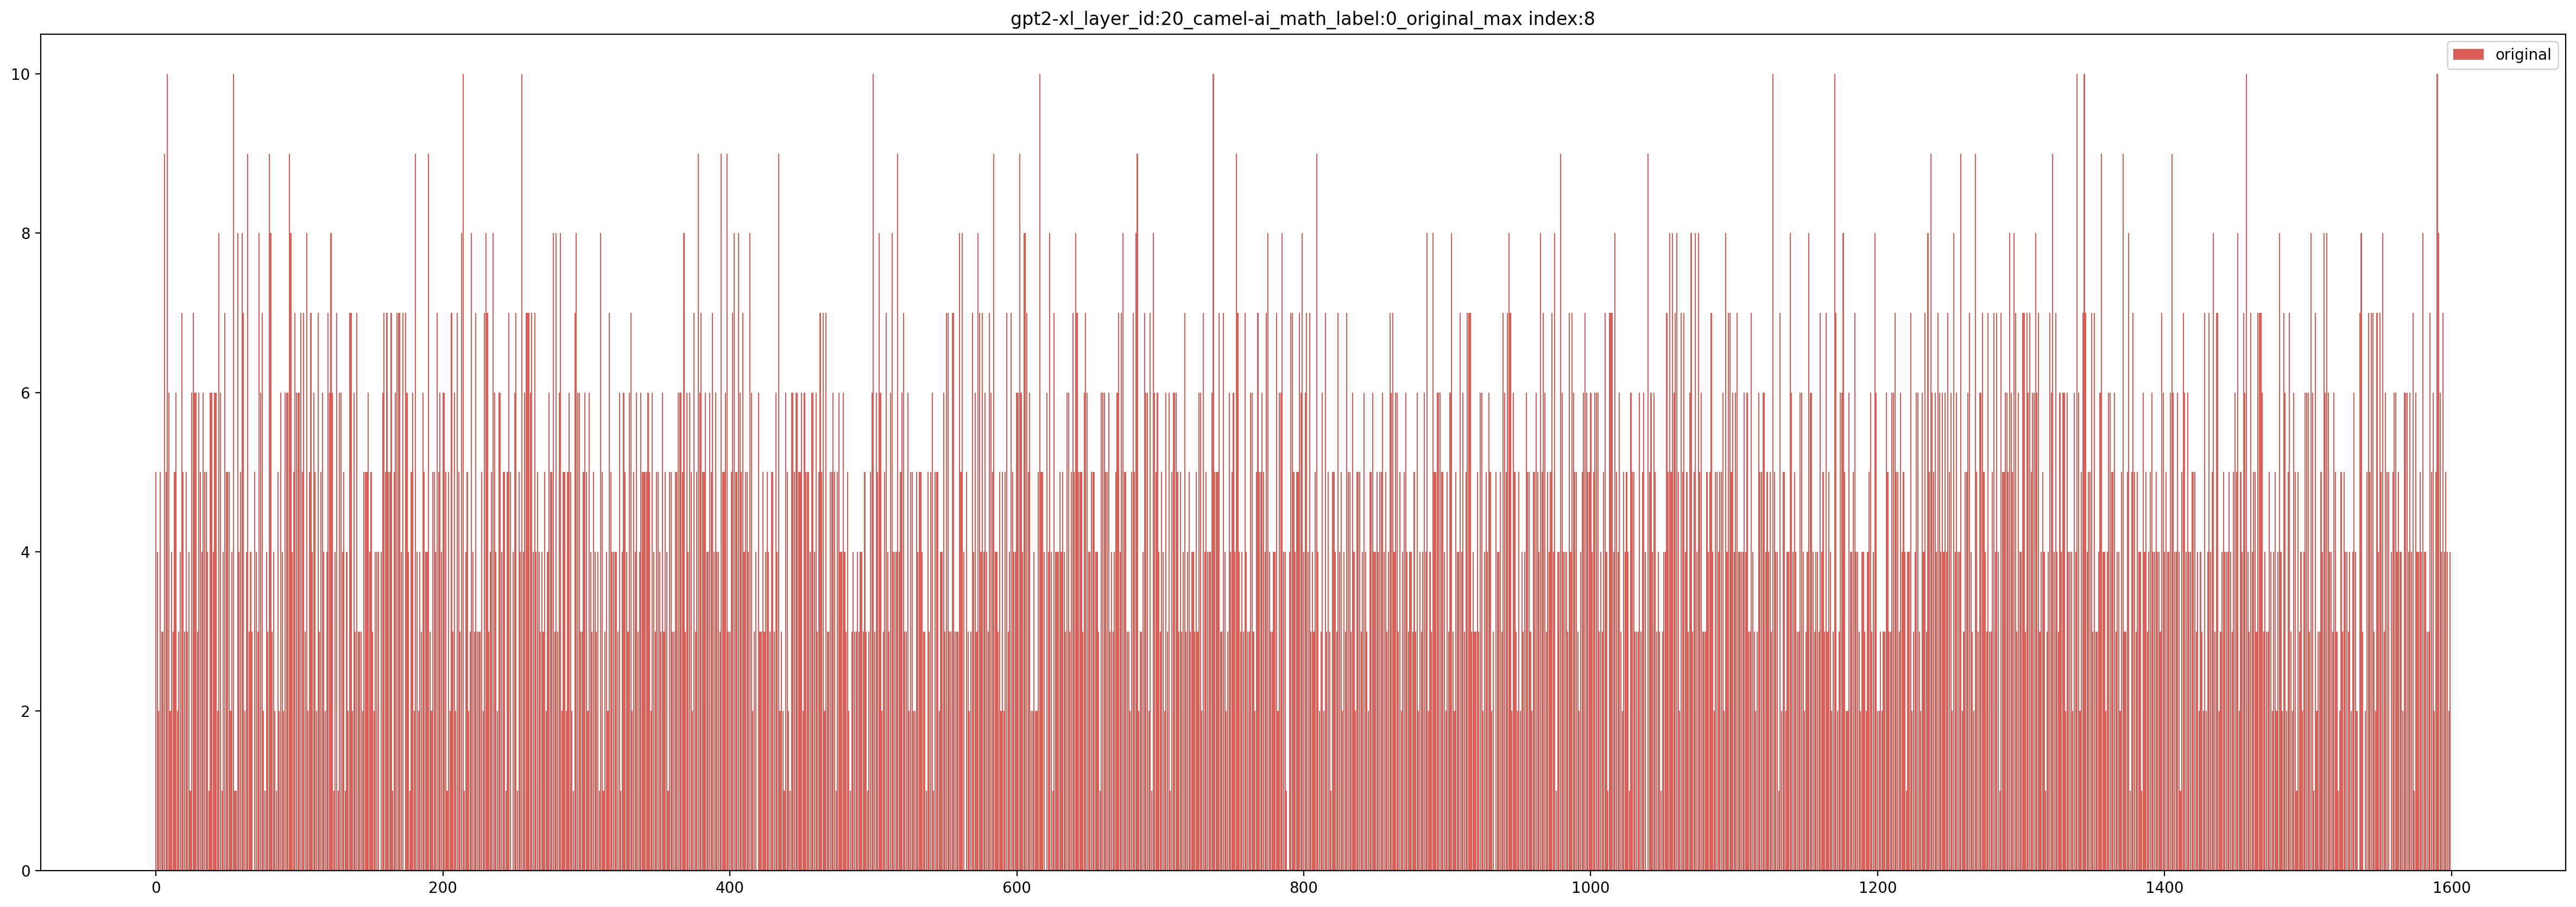

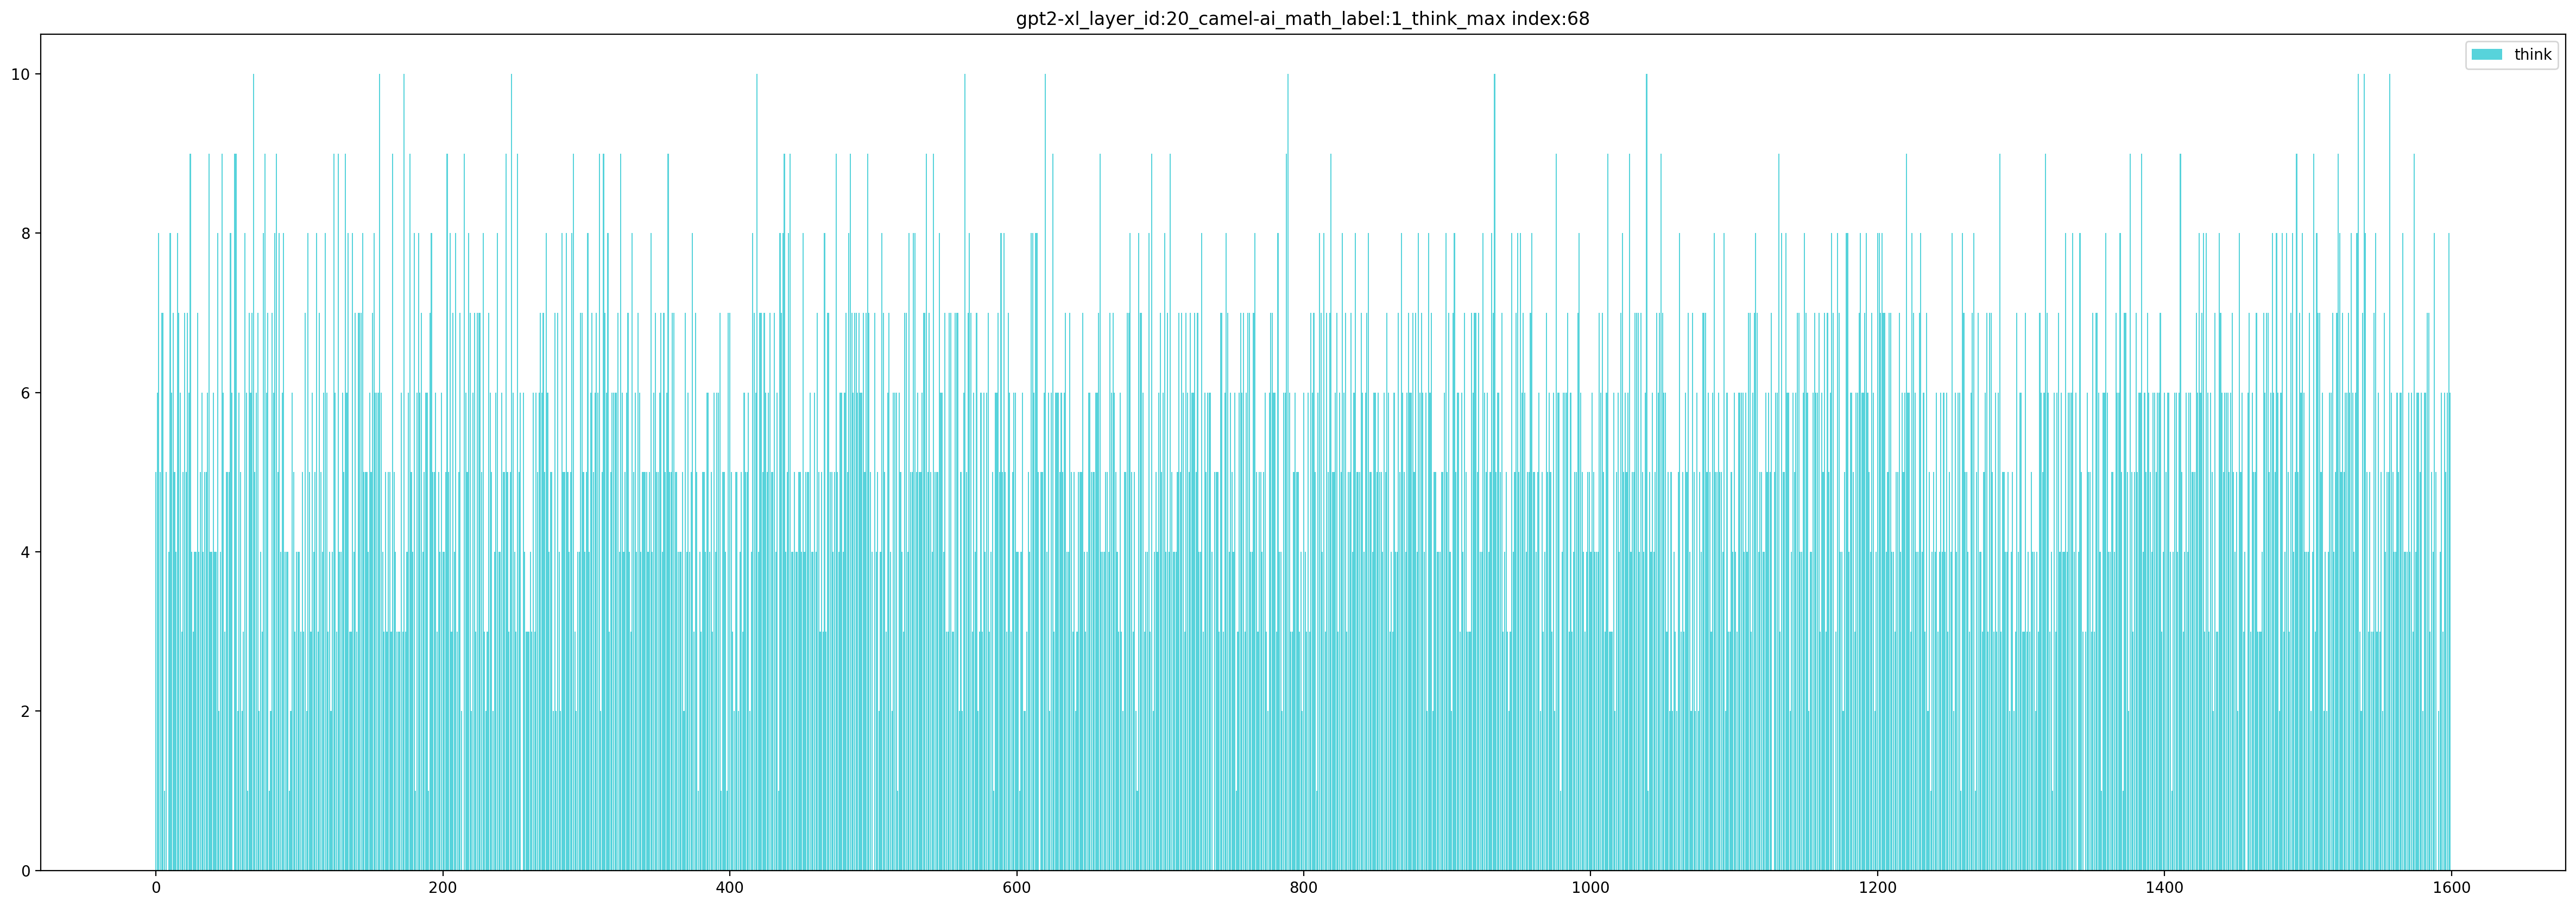

In [33]:
pd_index = range(0, top_k)
top = results[:, :top_k]
top_text = [text_list[i][:top_k] for i in range(len(text_list))]
result_top_pd, text_top_pd, max_index_list = plot_socre_label(results, top, top_text, dirs, datalabel, pd_index, title)

In [34]:
max_index_list,datalabel

([8, 68], ['original', 'think'])

In [35]:
result_top_pd.iloc[max_index_list]

0  1  2  3  4  5  6  7  8  9
8   0  0  0  0  0  0  0  0  0  0
68  1  1  1  1  1  1  1  1  1  1

In [36]:
text_top_pd.iloc[max_index_list]

0  \
8   What is the remainder when $7438+7439+7440+744...   
68  Let's think step by step:The digits $1$, $2$, ...   

                                                    1  \
8   What is the largest two-digit number that is d...   
68  Let's think step by step:How many positive fac...   

                                                    2  \
8   What is the greatest number of distinct positi...   
68  Let's think step by step:$12! = 47a001600$, fo...   

                                                    3  \
8   The digits $1$, $2$, $3$, $4$, $5$, $6$, $7$, ...   
68  Let's think step by step:What is the product (...   

                                                    4  \
8   What is the least positive integer multiple of...   
68  Let's think step by step:Find the product of $...   

                                                    5  \
8   What is the product (in base 10) of the first ...   
68  Let's think step by step:A positive multiple o...   

                                                    6  \
8   What is the least positive integer $n$ such th...   
68  Let's think step by step:What is the remainder...   

                                                    7  \
8   Compute $17^{-1}\pmod{83}$. Express your answe...   
68  Let's think step by step:What is the least pos...   

                                                    8  \
8   January 1, 2000 was on a Saturday. On what day...   
68  Let's think step by step:Compute $17^{-1}\pmod...   

                                                    9  
8   Remove the integers which are congruent to 3 (...  
68  Let's think step by step:What is the largest t...

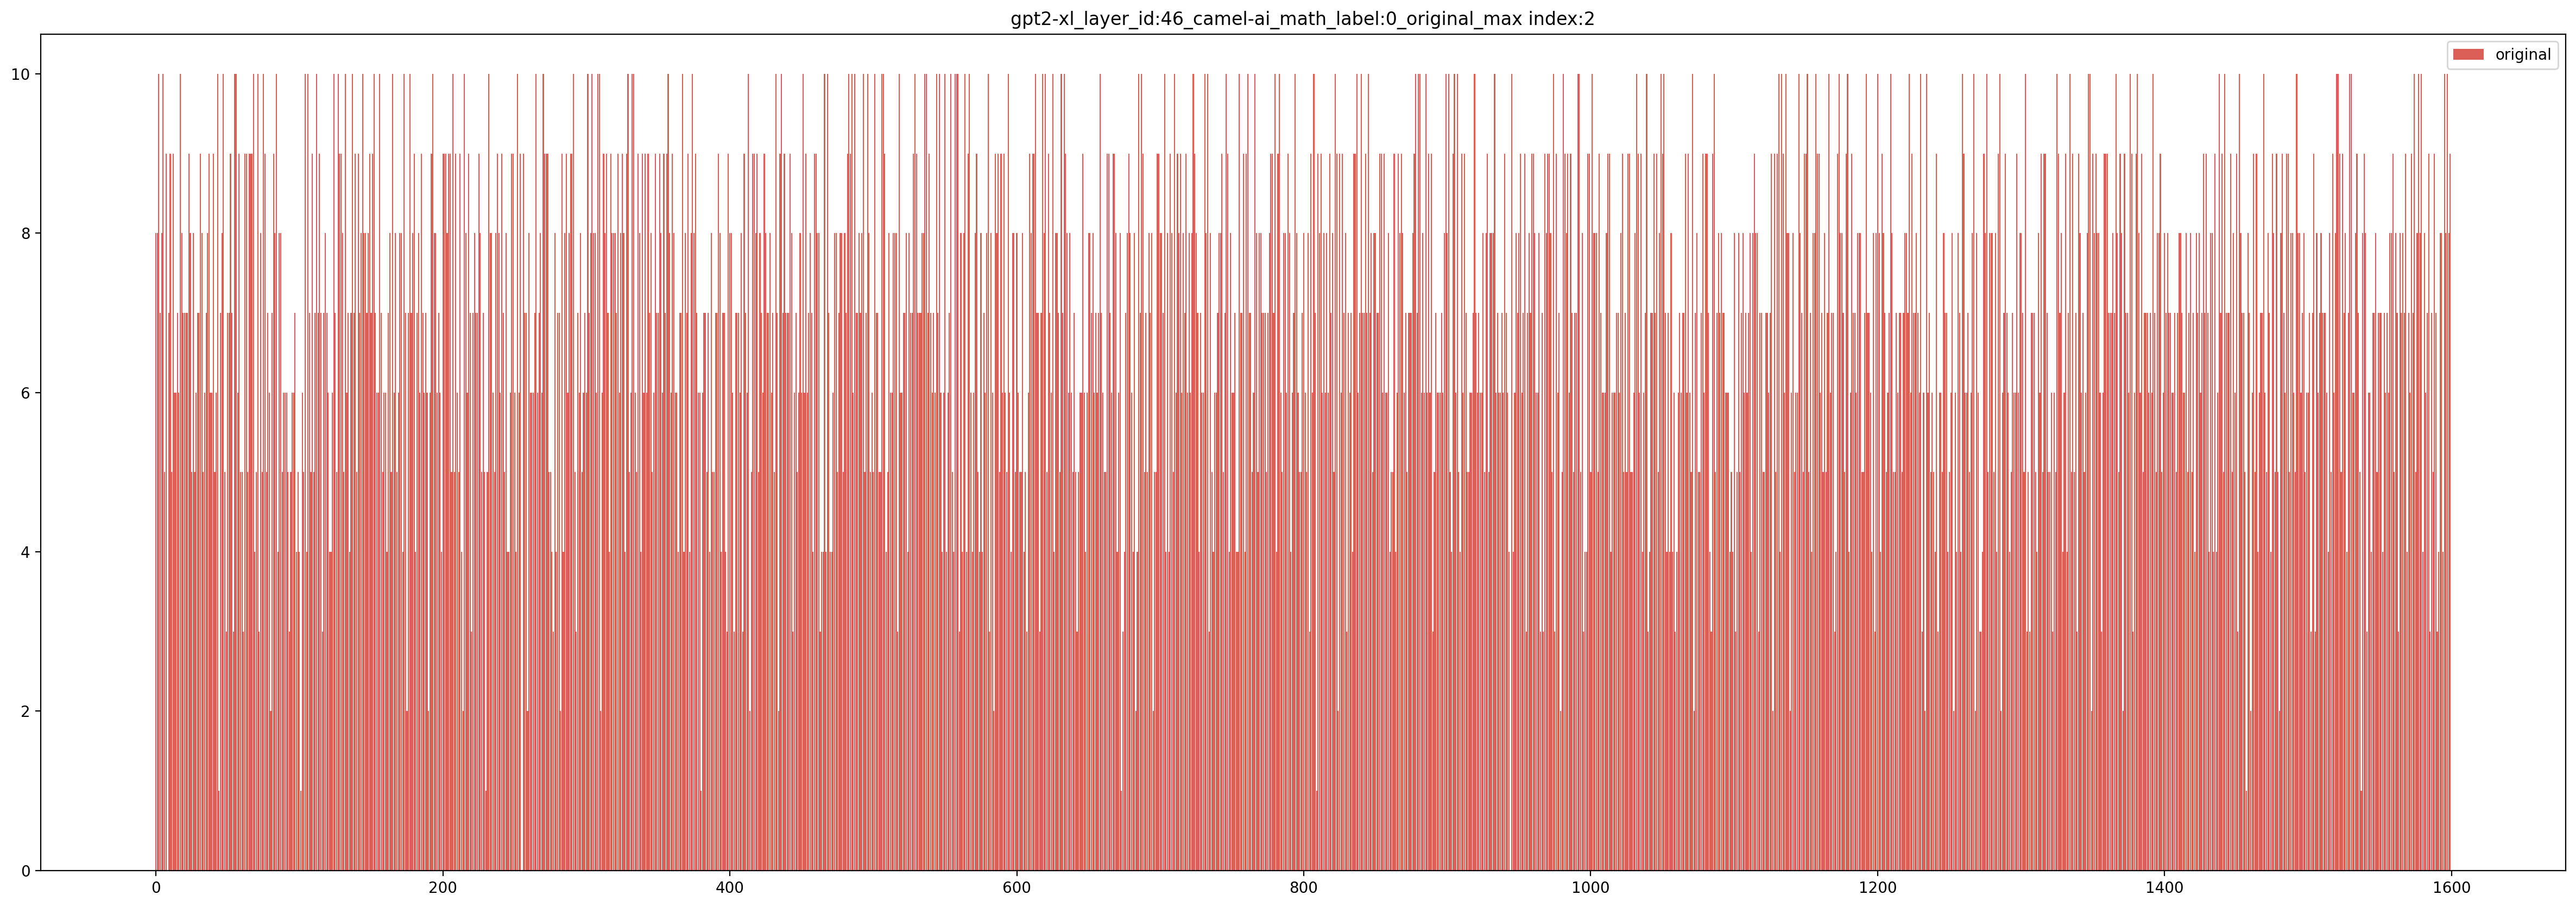

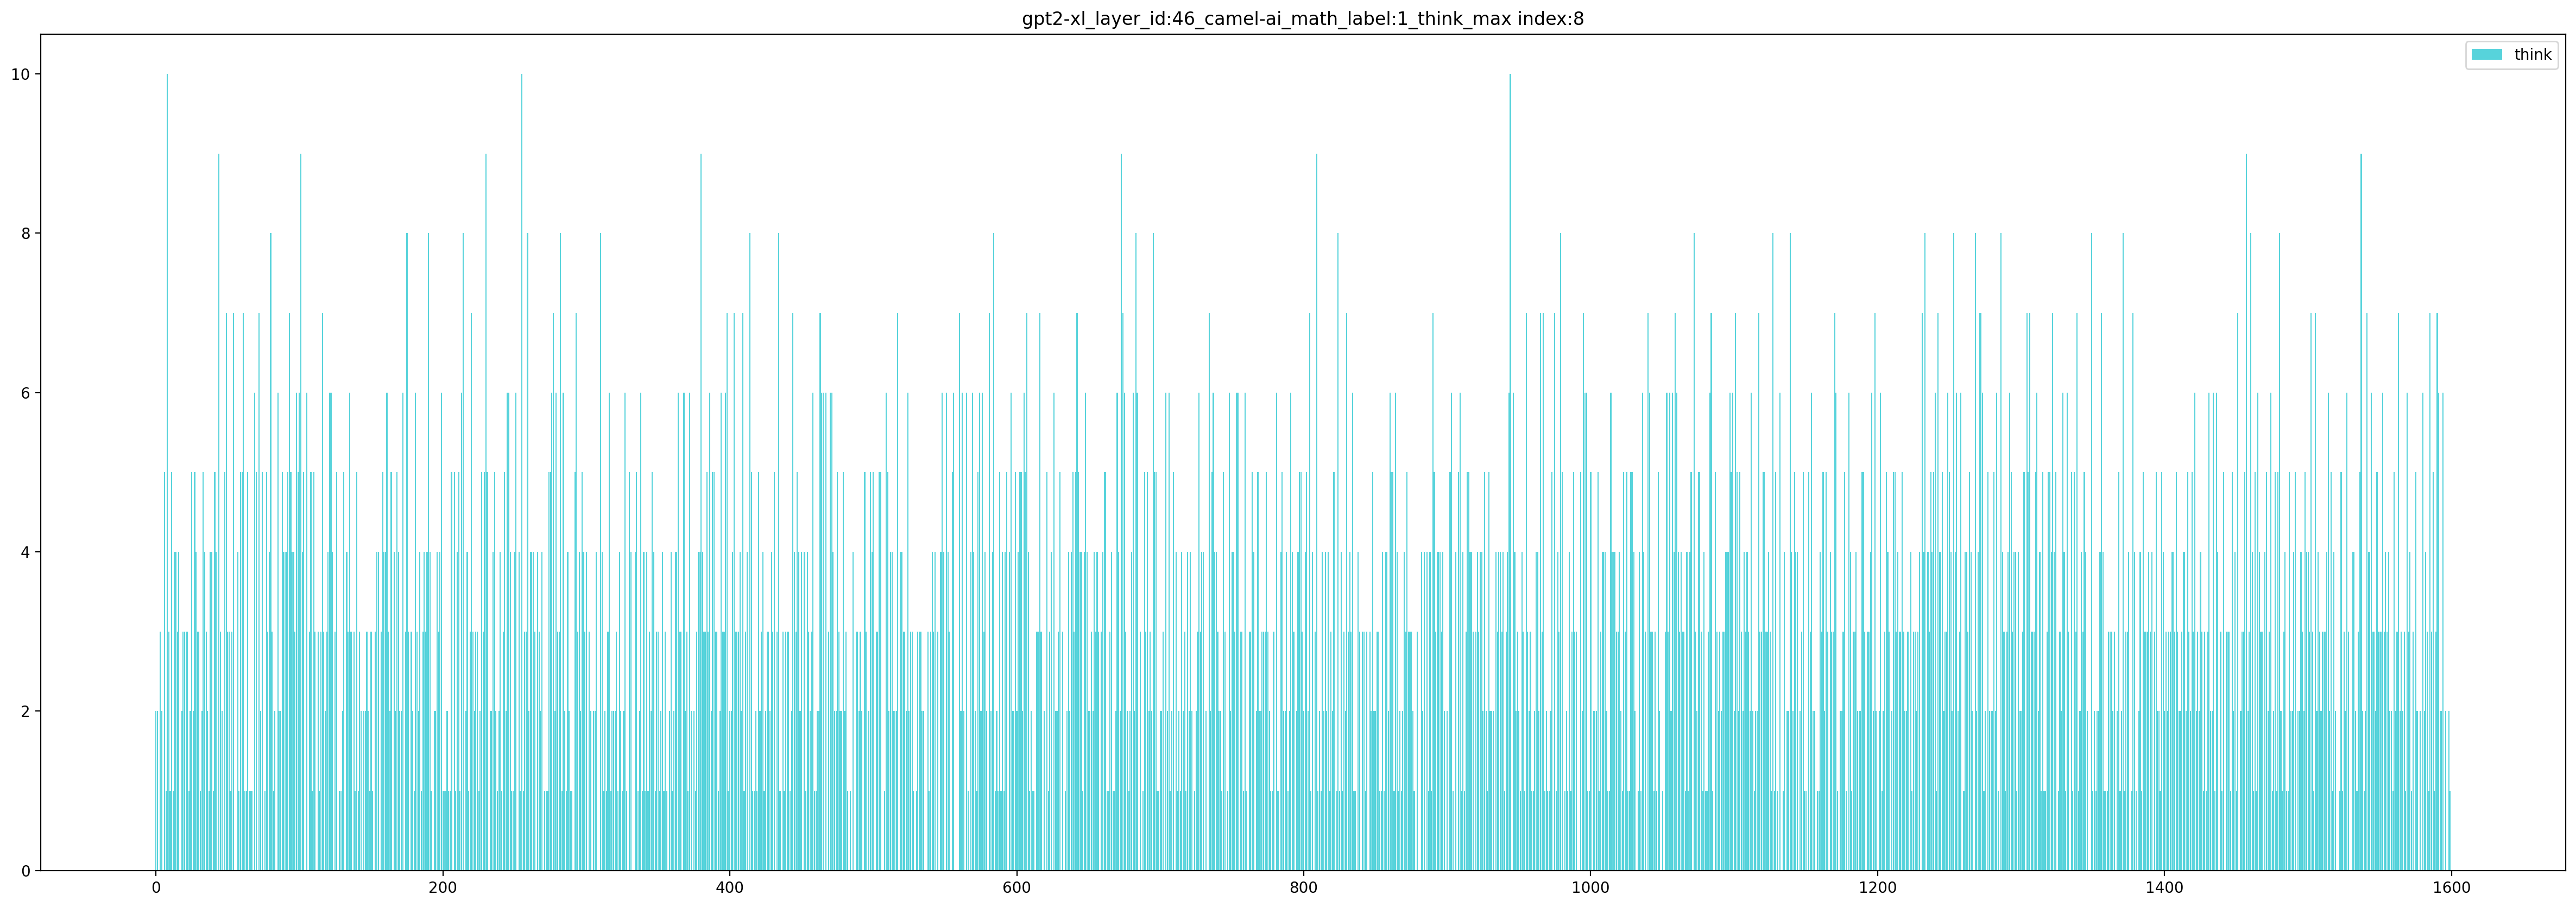

In [13]:
pd_index = range(results.shape[1] - top_k, results.shape[1])
top = results[:, -top_k:]
top_text = [text_list[i][-top_k:] for i in range(len(text_list))]
result_last_pd, text_last_pd, last_index_list = plot_socre_label(results, top, top_text, dirs, datalabel, pd_index, title)

In [18]:
last_index_list,datalabel

([2, 8], ['original', 'think'])

In [19]:
result_last_pd.iloc[last_index_list]

91   92   93   94   95   96   97   98   99   100
2    0    0    0    0    0    0    0    0    0    0
8    1    1    1    1    1    1    1    1    1    1

In [21]:
text_last_pd.iloc[last_index_list]

91   \
2  Convert the repeating decimal $3.283283283\ldo...   
8  Let's think step by step:Suppose that $a$ is a...   

                                                 92   \
2  What integer $n$ satisfies $0\le n<{101}$ and ...   
8  Let's think step by step:In this problem, $m$ ...   

                                                 93   \
2  What is the smallest positive integer $n$ such...   
8  Let's think step by step:Kim's birthday was 20...   

                                                 94   \
2  A bus comes by Jerry's bus stop every 20 minut...   
8  Let's think step by step:If the least common m...   

                                                 95   \
2  For how many integers $n$ from $1$ to $29$ is ...   
8  Let's think step by step:Find $n$ if $\gcd(n,4...   

                                                 96   \
2  Determine the number of solutions in $x$ of th...   
8  Let's think step by step:Find the remainder of...   

                                                 97   \
2  Find the units digit of the following:  \begin...   
8  Let's think step by step:Find the remainder wh...   

                                                 98   \
2  If $a\equiv 62\pmod{99}$ and $b\equiv 75\pmod{...   
8  Let's think step by step:If $x=720$ and $ax$ i...   

                                                 99   \
2  Find $n$ if $\gcd(n,40) = 10$ and $\mathop{\te...   
8  Let's think step by step:Find the unique $\tex...   

                                                 100  
2  In base $10,$ $44 \times 55$ does not equal $3...  
8  Let's think step by step:Find the modulo 4 res...

## draw common

[(0, 'original', array([0., 0., 0., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])), (1, 'think', array([0., 0., 0., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))]


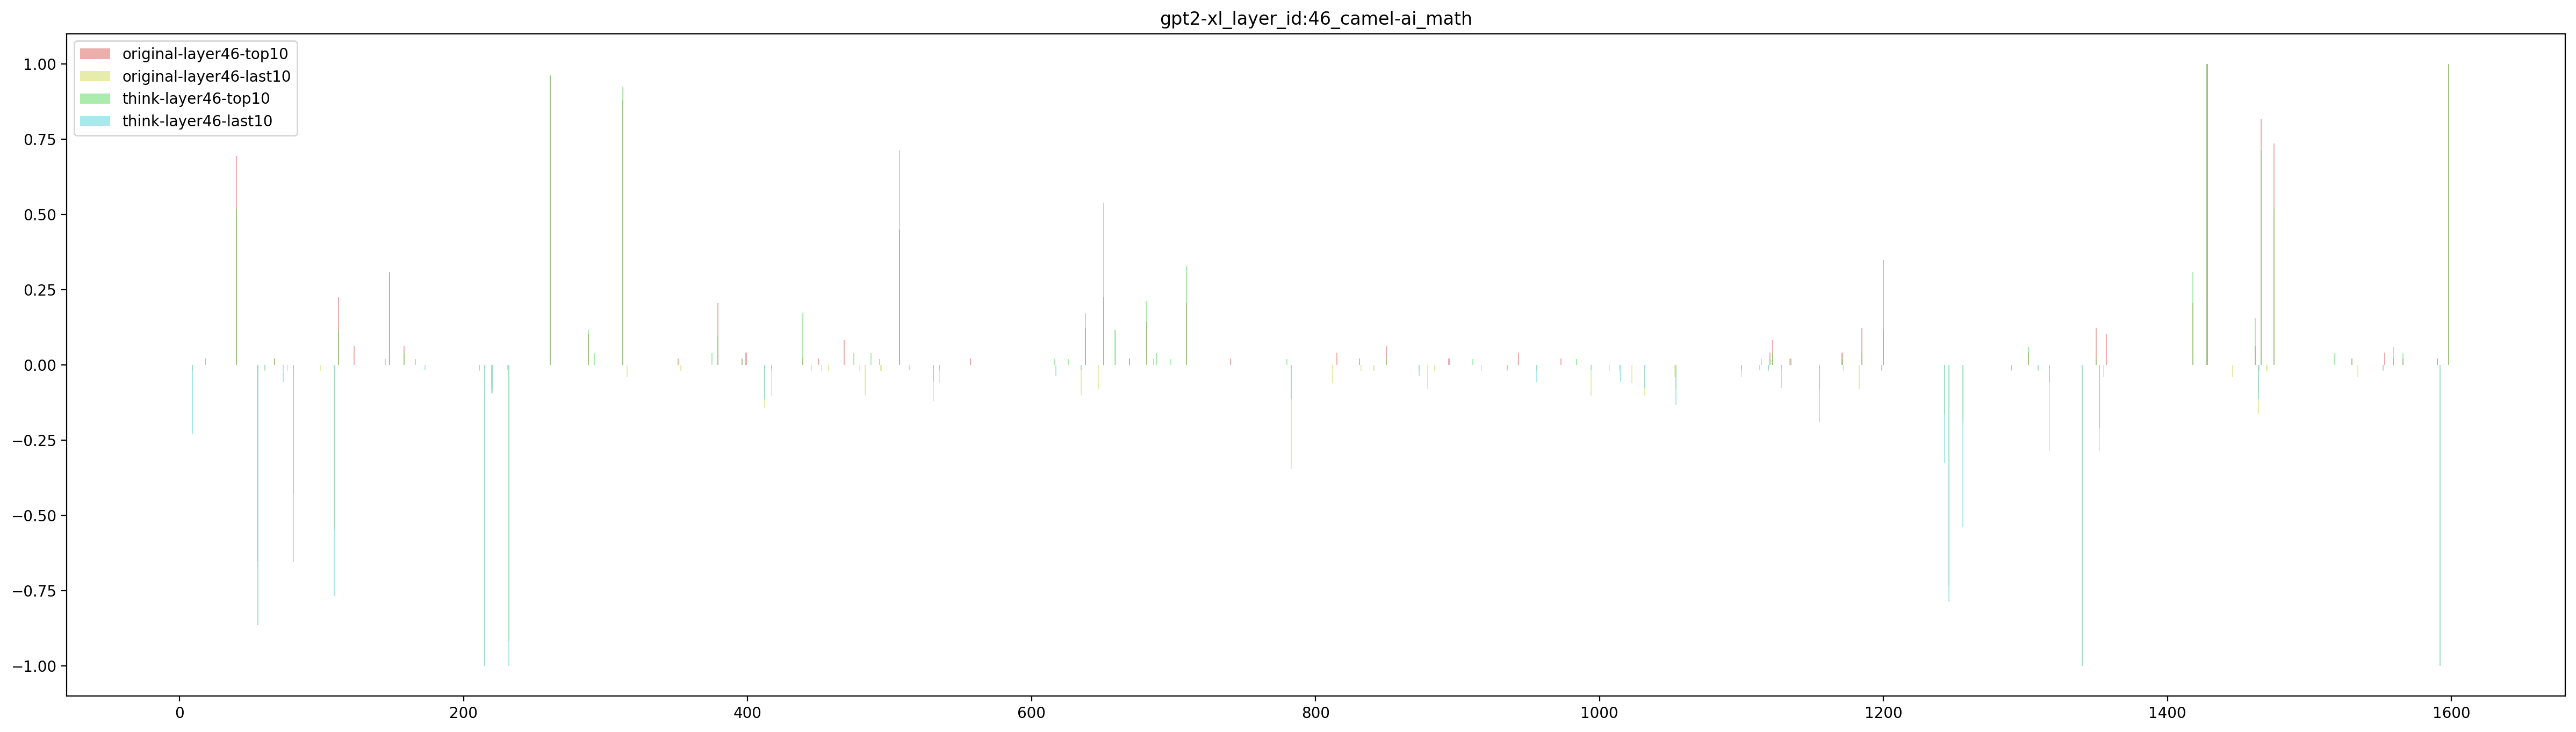

In [22]:
d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
unit_num = activations.shape[-1]
sentence_num = activations.shape[0]
data_pd = pd.DataFrame(activations,
             index=[f"sentence{i}" for i in range(sentence_num)],
             columns=[f"unit{i}" for i in range(unit_num)])
data_pd['label'] = d['label']

# draw common
stat = plot_common_max_min(data_pd, layer_id, top_k, datalabel, title, dir_path)
print(stat)

In [37]:
standard_top, standard_last = 0.8, 0.8
label_i, label_name, stat_top, stat_last = stat[0]
top_index = np.nonzero(stat_top>standard_top)
last_index = np.nonzero(stat_last>standard_last)
print(f'{label_name}:{datalabel}')

original:['original', 'think']


In [38]:
result_top_pd.iloc[top_index]

0  1  2  3  4  5  6  7  8  9
260   0  0  1  1  0  0  0  0  0  1
311   1  1  0  0  0  1  1  1  0  0
1427  1  0  1  1  1  1  1  1  0  1
1465  0  0  0  1  1  1  0  0  0  0
1597  0  1  1  0  1  1  1  0  0  1

In [39]:
text_top_pd.iloc[top_index]

0  \
260   January 1, 2000 was on a Saturday. On what day...   
311   Let's think step by step:The digits $1$, $2$, ...   
1427  Let's think step by step:How many positive fac...   
1465  Find the units digit of the following:  \begin...   
1597  In base $10,$ $44 \times 55$ does not equal $3...   

                                                      1  \
260   Find the units digit of the following:  \begin...   
311   Let's think step by step:Compute $17^{-1}\pmod...   
1427  How many positive factors of 4000 are multiple...   
1465  Remove the integers which are congruent to 3 (...   
1597  Let's think step by step:Compute $121_3+2122_3...   

                                                      2  \
260   Let's think step by step:Find the units digit ...   
311   Compute $17^{-1}\pmod{83}$. Express your answe...   
1427  Let's think step by step:What is the product (...   
1465  Remove the integers which are congruent to 3 (...   
1597  Let's think step by step:Compute $121_3+2122_3...   

                                                      3  \
260   Let's think step by step:January 1, 2000 was o...   
311   The digits $1$, $2$, $3$, $4$, $5$, $6$, $7$, ...   
1427  Let's think step by step:A positive multiple o...   
1465  Let's think step by step:Remove the integers w...   
1597  January 1, 2000 was on a Saturday. On what day...   

                                                      4  \
260   $12! = 47a001600$, for some digit $a$. What is...   
311   Find the remainder of $2^8$ when it is divided...   
1427  Let's think step by step:What is the greatest ...   
1465  Let's think step by step:Remove the integers w...   
1597  Let's think step by step:The digits $1$, $2$, ...   

                                                      5  \
260   A bus comes by Jerry's bus stop every 20 minut...   
311   Let's think step by step:A positive multiple o...   
1427  Let's think step by step:$12! = 47a001600$, fo...   
1465  Let's think step by step:Find the units digit ...   
1597  Let's think step by step:Kim's birthday was 20...   

                                                      6  \
260   Remove the integers which are congruent to 3 (...   
311   Let's think step by step:Remove the integers w...   
1427  Let's think step by step:What is the least pos...   
1465  Find $n$ if $\gcd(n,40) = 10$ and $\mathop{\te...   
1597  Let's think step by step:January 1, 2000 was o...   

                                                      7  \
260   Remove the integers which are congruent to 3 (...   
311   Let's think step by step:Remove the integers w...   
1427  Let's think step by step:What is the smallest ...   
1465  Determine the number of solutions in $x$ of th...   
1597  The digits $1$, $2$, $3$, $4$, $5$, $6$, $7$, ...   

                                                      8  \
260   In base $10,$ $44 \times 55$ does not equal $3...   
311   Remove the integers which are congruent to 3 (...   
1427  Find the remainder of $2^8$ when it is divided...   
1465  If $a\equiv 62\pmod{99}$ and $b\equiv 75\pmod{...   
1597  Find the remainder of $2^8$ when it is divided...   

                                                      9  
260   Let's think step by step:Kim's birthday was 20...  
311   Remove the integers which are congruent to 3 (...  
1427  Let's think step by step:January 1, 2000 was o...  
1465  Compute $121_3+2122_3-1200_3-2111_3$. Express ...  
1597  Let's think step by step:How many positive fac...

In [40]:
result_last_pd.iloc[last_index]

91   92   93   94   95   96   97   98   99   100
214     1    1    1    1    1    0    1    0    1    1
231     1    1    1    1    1    0    0    0    0    0
1339    1    1    1    0    1    0    0    1    1    1
1591    0    1    1    0    1    0    1    1    1    0

In [41]:
text_last_pd.iloc[last_index]

91   \
214   Let's think step by step:How many integers fro...   
231   Let's think step by step:Find the modulo $7$ r...   
1339  Let's think step by step:Compute $121_3+2122_3...   
1591        Find the modulo 4 residue of $17 \cdot 18$.   

                                                    92   \
214   Let's think step by step:Find the product of $...   
231   Let's think step by step:Find the modulo $7$ r...   
1339  Let's think step by step:Compute $121_3+2122_3...   
1591  Let's think step by step:What is the greatest ...   

                                                    93   \
214   Let's think step by step:Find the modulo 4 res...   
231   Let's think step by step:In this problem, $a$ ...   
1339  Let's think step by step:$12! = 47a001600$, fo...   
1591  Let's think step by step:What is the product (...   

                                                    94   \
214   Let's think step by step:Convert the repeating...   
231   Let's think step by step:Compute $121_3+2122_3...   
1339  A bus comes by Jerry's bus stop every 20 minut...   
1591  In base $10,$ $44 \times 55$ does not equal $3...   

                                                    95   \
214   Let's think step by step:Convert the repeating...   
231   Let's think step by step:Compute $121_3+2122_3...   
1339  Let's think step by step:A bus comes by Jerry'...   
1591  Let's think step by step:$12! = 47a001600$, fo...   

                                                    96   \
214   A bus comes by Jerry's bus stop every 20 minut...   
231   In this problem, $a$ and $b$ are integers, suc...   
1339  In base $10,$ $44 \times 55$ does not equal $3...   
1591  $12! = 47a001600$, for some digit $a$. What is...   

                                                    97   \
214   Let's think step by step:A bus comes by Jerry'...   
231   In this problem, $a$ and $b$ are integers, suc...   
1339  January 1, 2000 was on a Saturday. On what day...   
1591  Let's think step by step:How many positive fac...   

                                                    98   \
214   January 1, 2000 was on a Saturday. On what day...   
231   Find $n$ if $\gcd(n,40) = 10$ and $\mathop{\te...   
1339  Let's think step by step:January 1, 2000 was o...   
1591  Let's think step by step:January 1, 2000 was o...   

                                                    99   \
214   Let's think step by step:Kim's birthday was 20...   
231   Find the modulo $7$ remainder of the sum $1+3+...   
1339  Let's think step by step:Kim's birthday was 20...   
1591  Let's think step by step:Kim's birthday was 20...   

                                                    100  
214   Let's think step by step:January 1, 2000 was o...  
231   Find the modulo $7$ remainder of the sum $1+3+...  
1339  Let's think step by step:How many positive fac...  
1591  January 1, 2000 was on a Saturday. On what day...

## draw umap

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


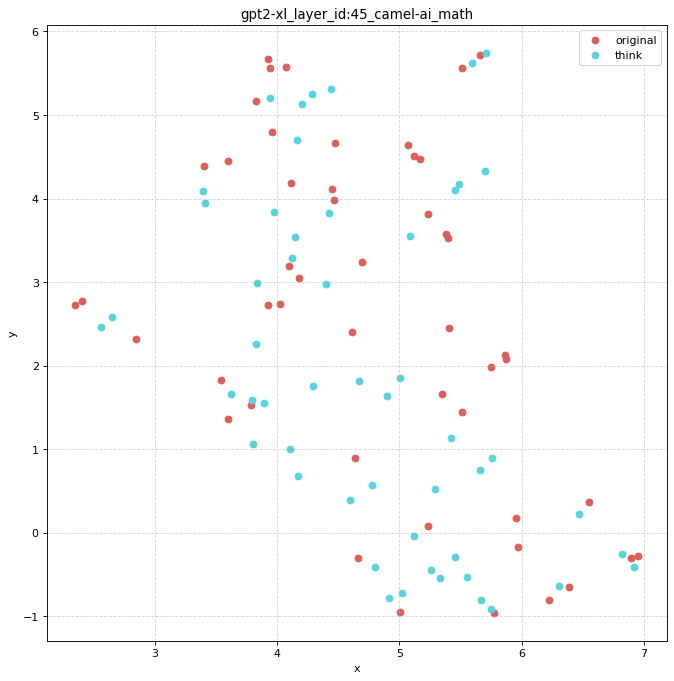

In [28]:
# draw umap
layer_id = 45
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
y_array = np.array(d['label'])
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"
plot_umap(activations, y_array, datalabel, title, dir_path)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


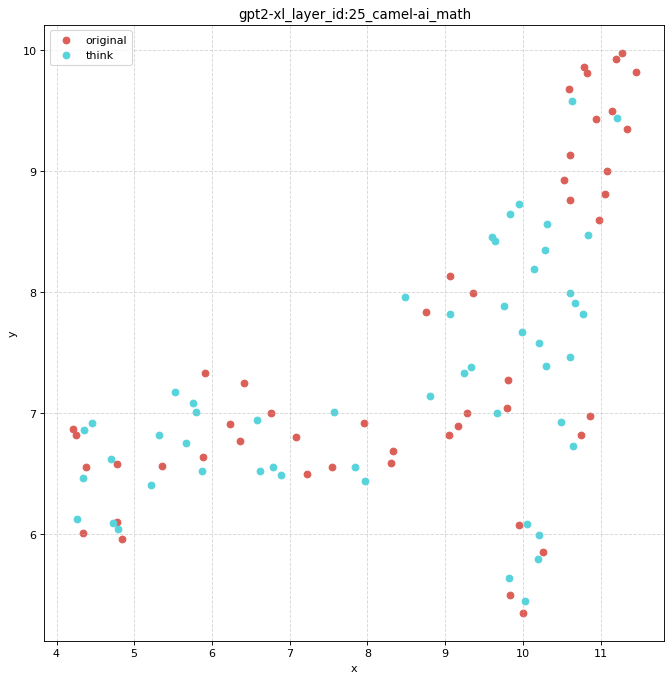

In [29]:
# draw umap
layer_id = 25
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
y_array = np.array(d['label'])
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"
datalabel = datalabels[key]
plot_umap(activations, y_array, datalabel, title, dir_path)

## draw score values

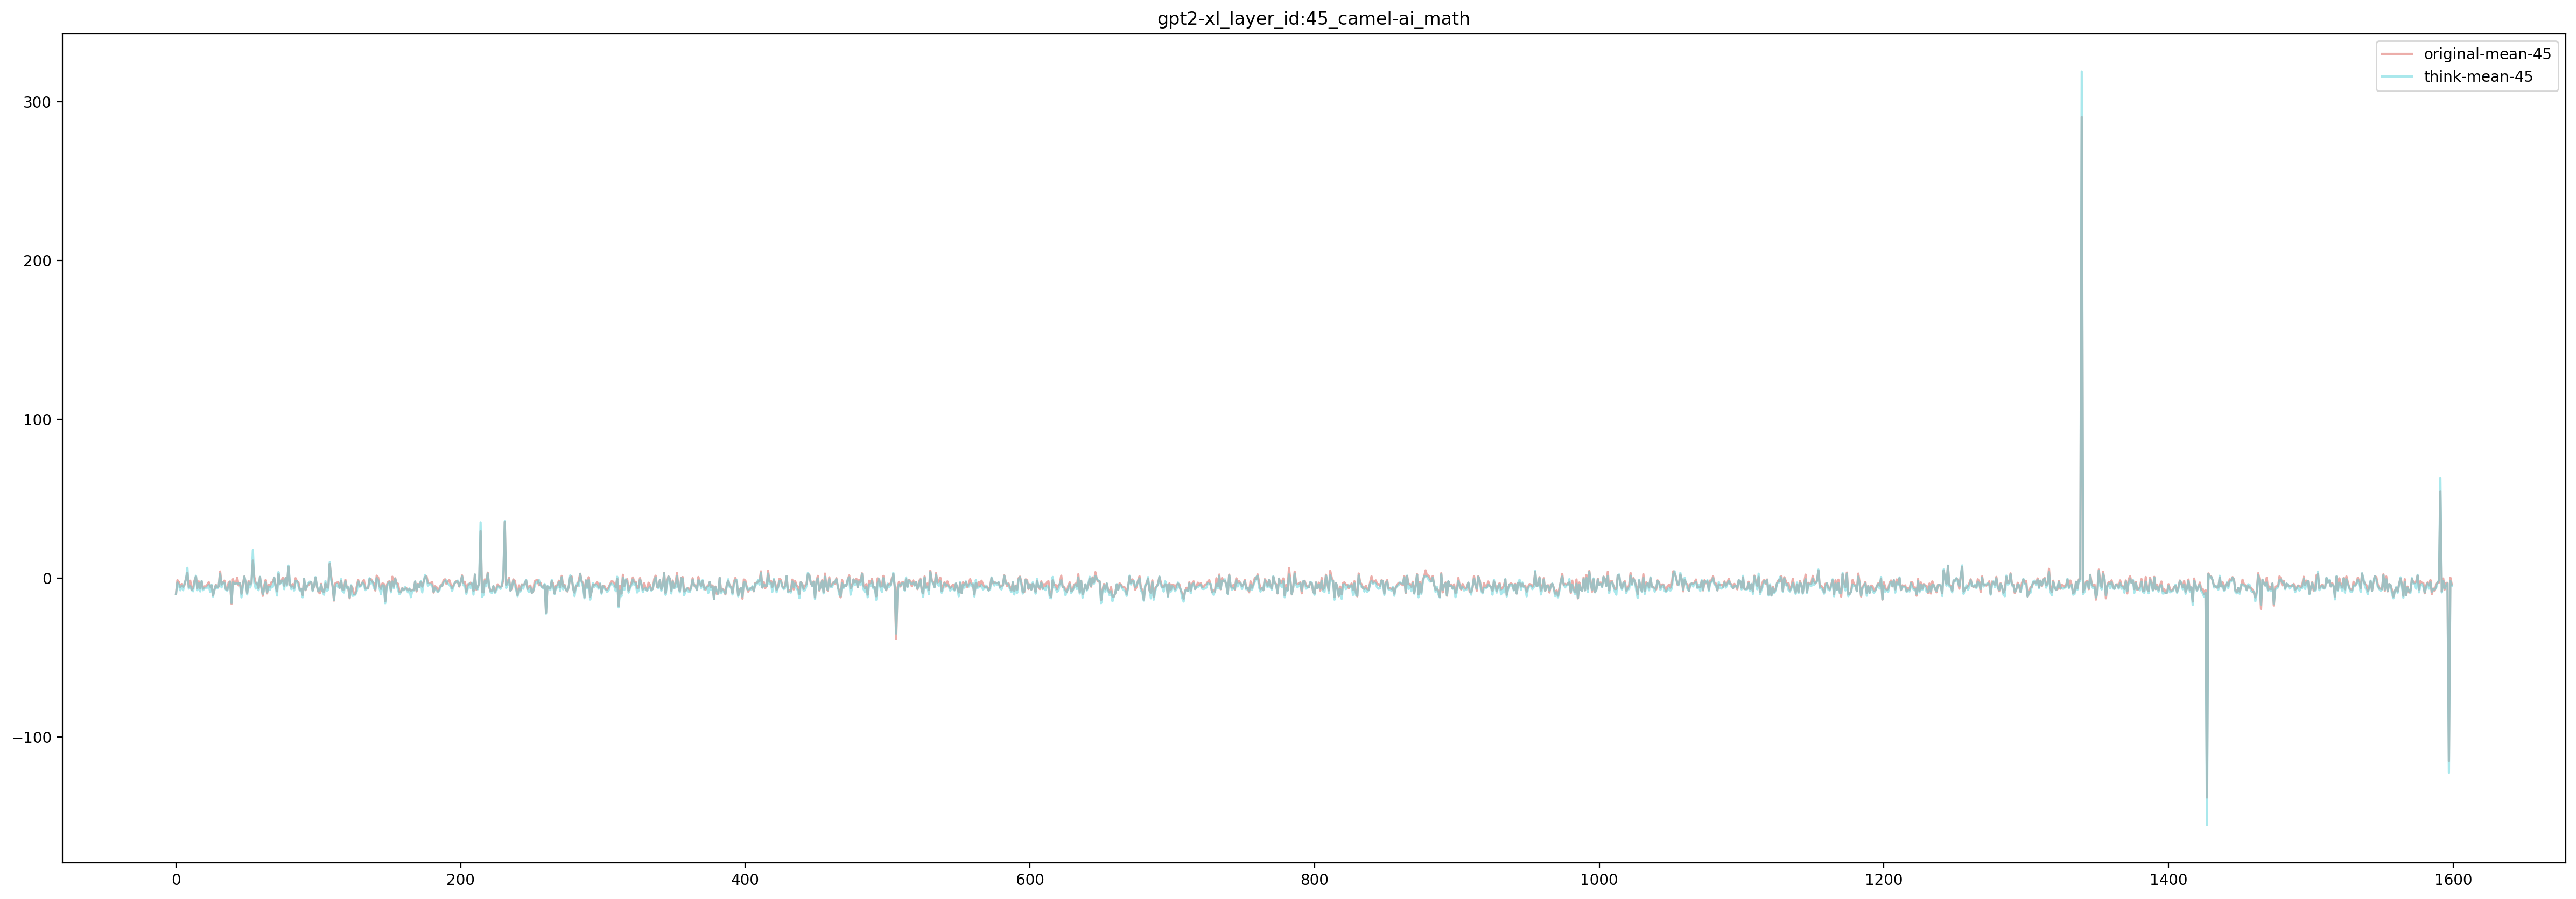

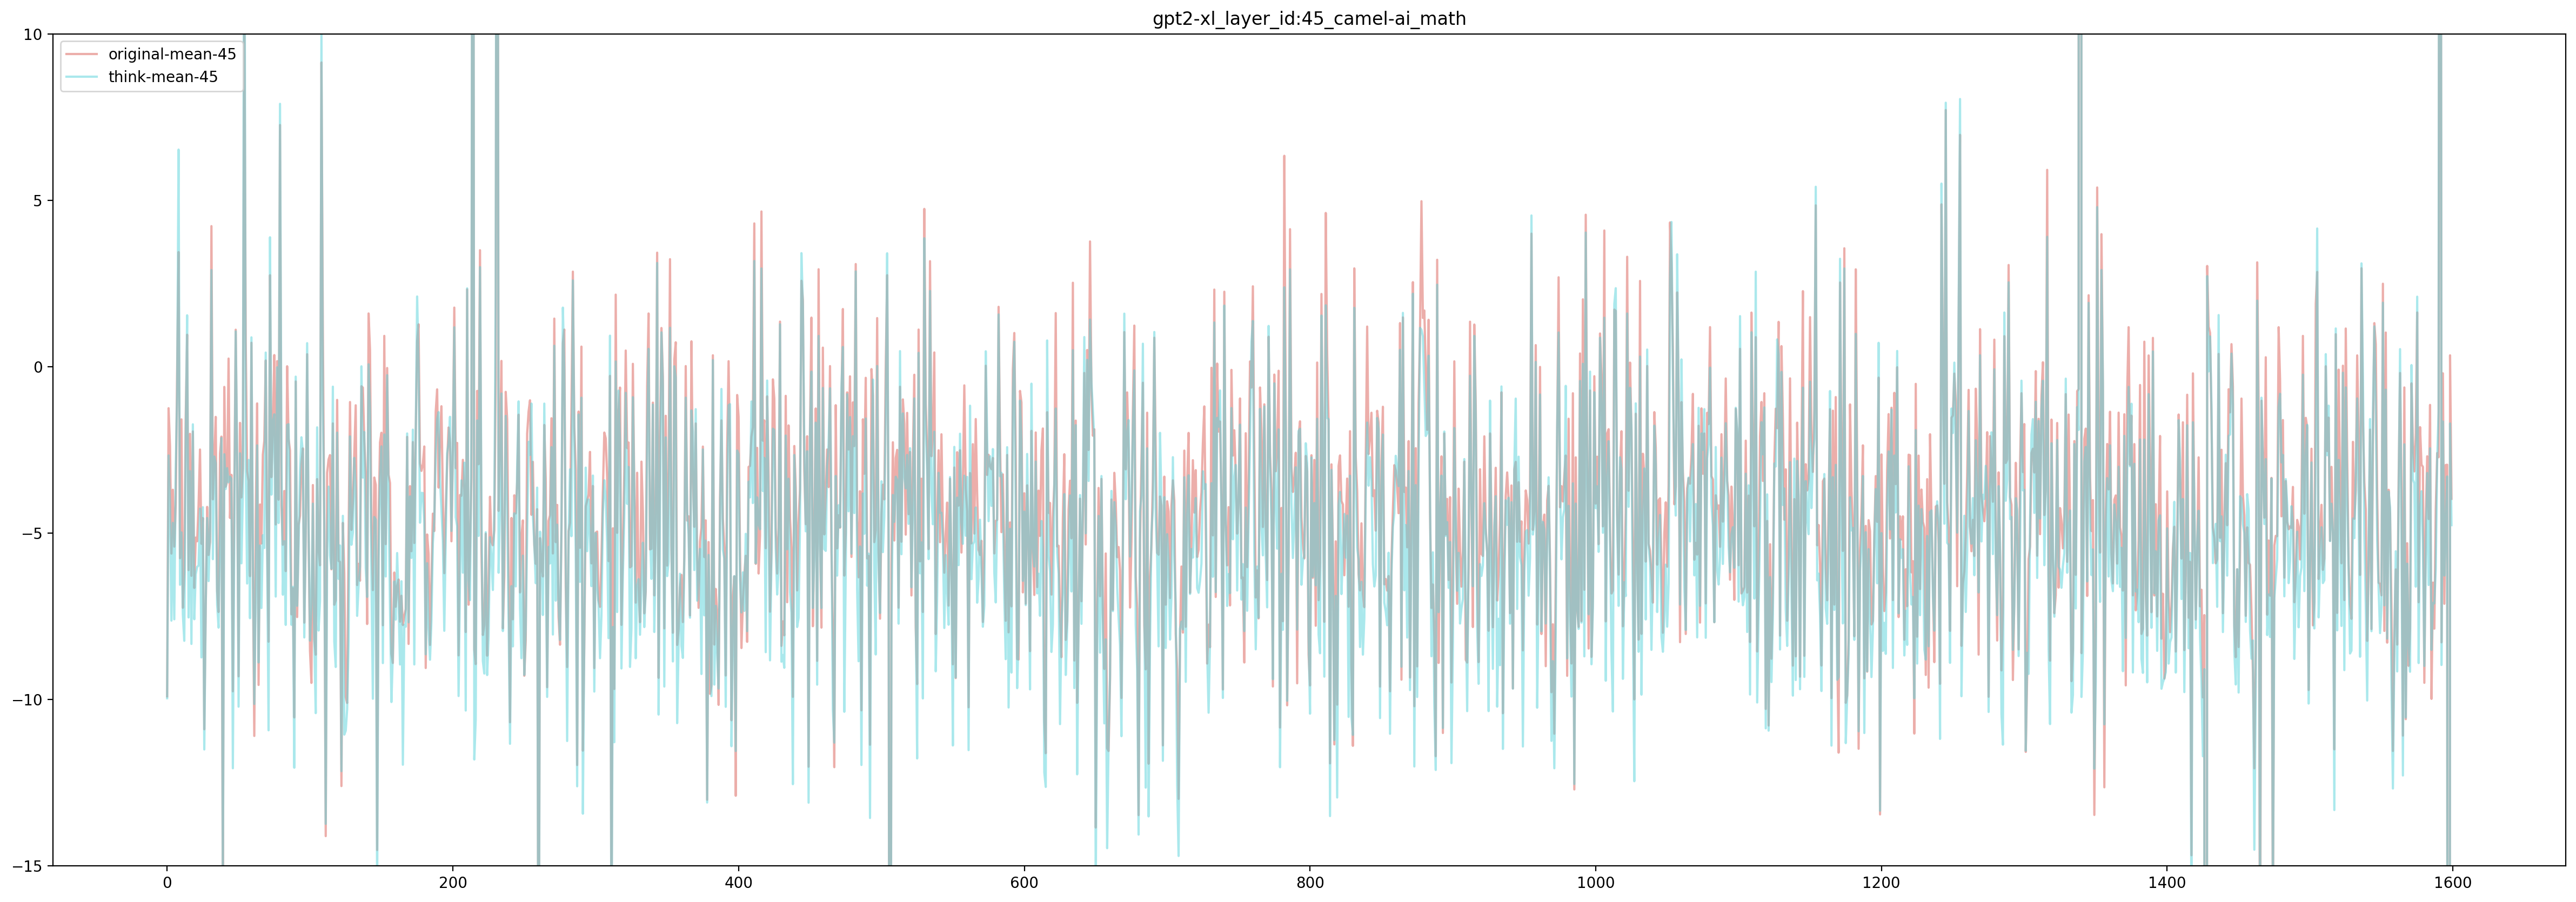

In [30]:
layer_id = 45
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
unit_num = activations.shape[-1]
x = range(unit_num)
data_pd = get_data_pd(d, layer_id)

mean_pd = data_pd.groupby(['label']).mean()
plot_line(x, mean_pd, datalabel, "mean", layer_id, None, title, dir_path, False)
# print(min_pd)
plot_line(x, mean_pd, datalabel, "mean", layer_id, [-15,10], title, dir_path, False)

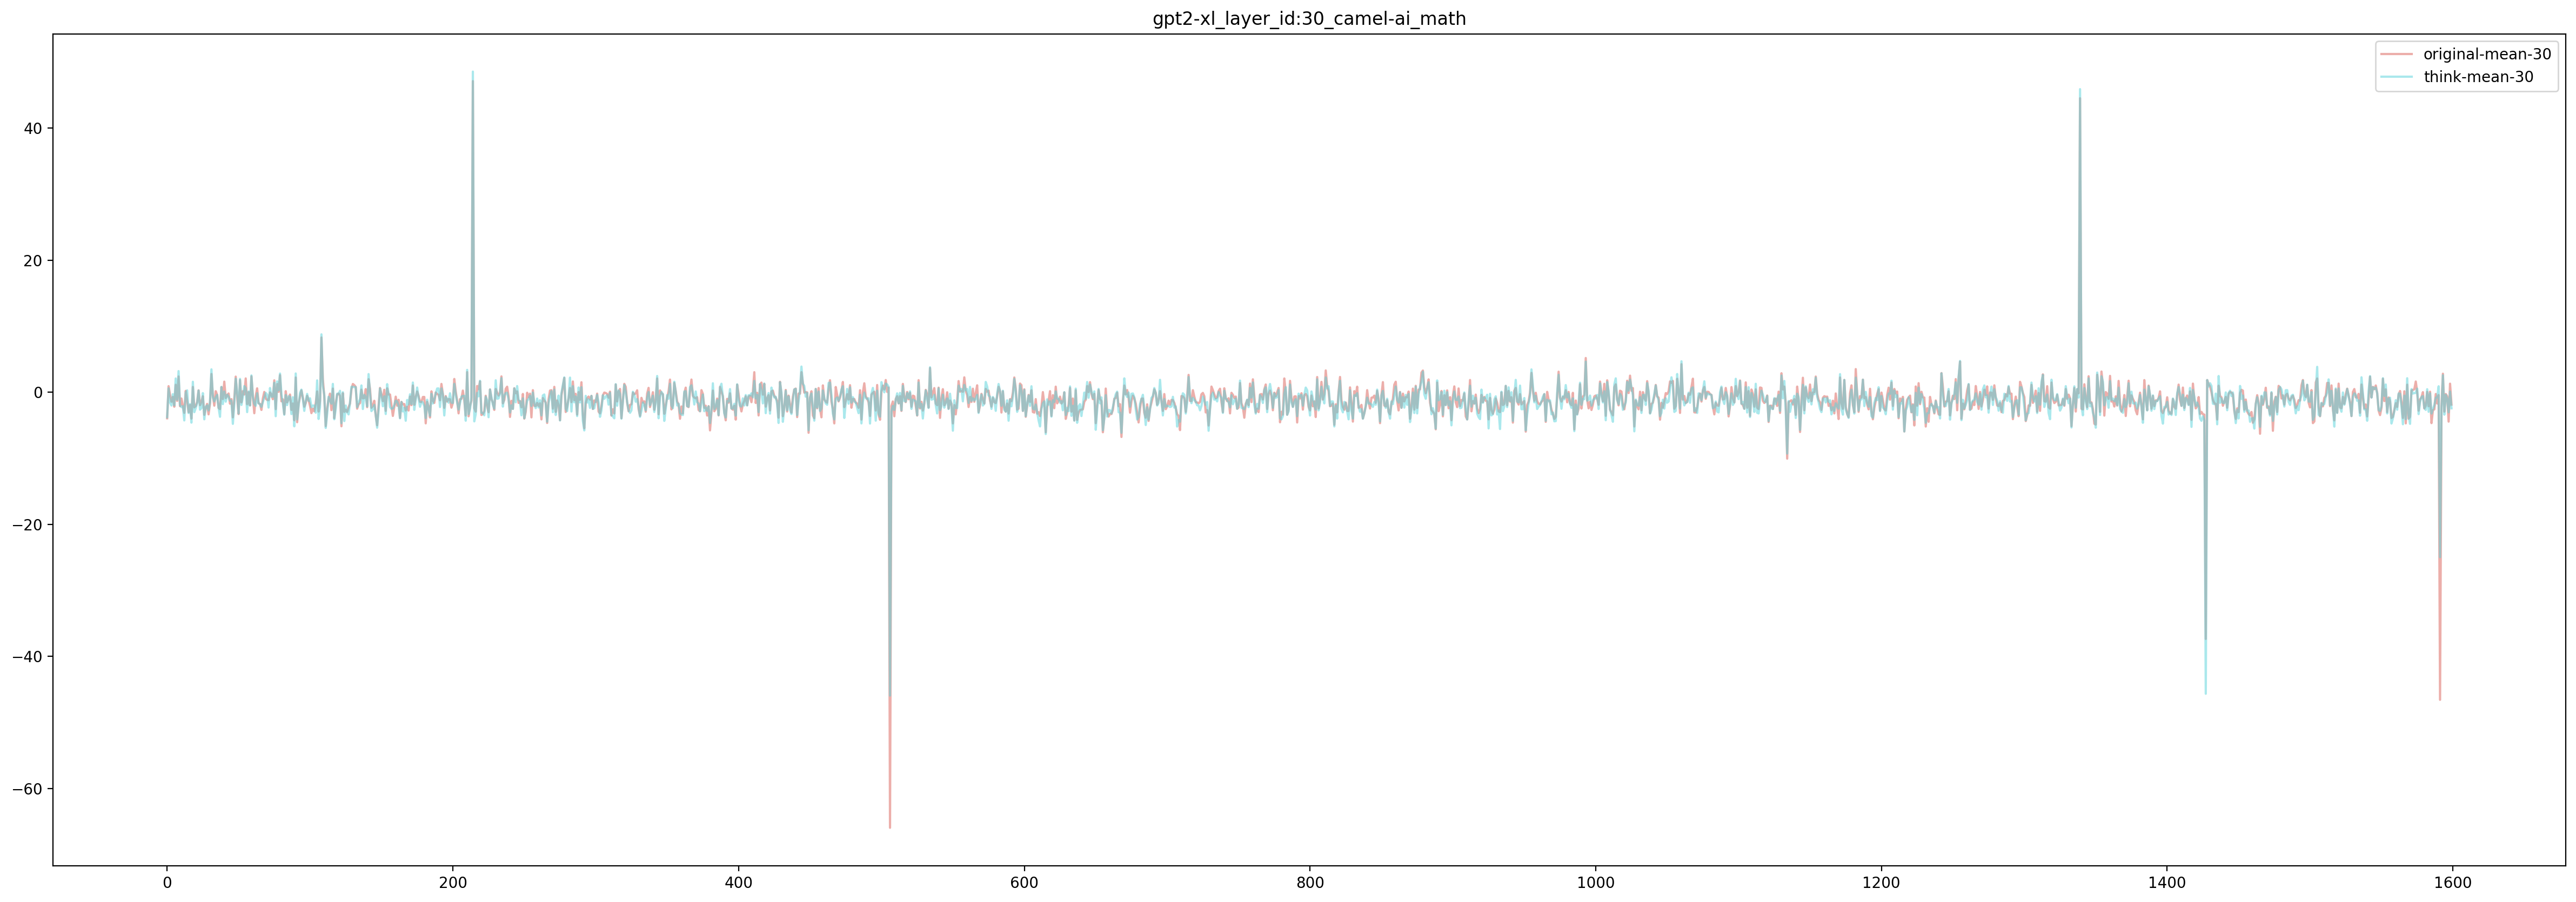

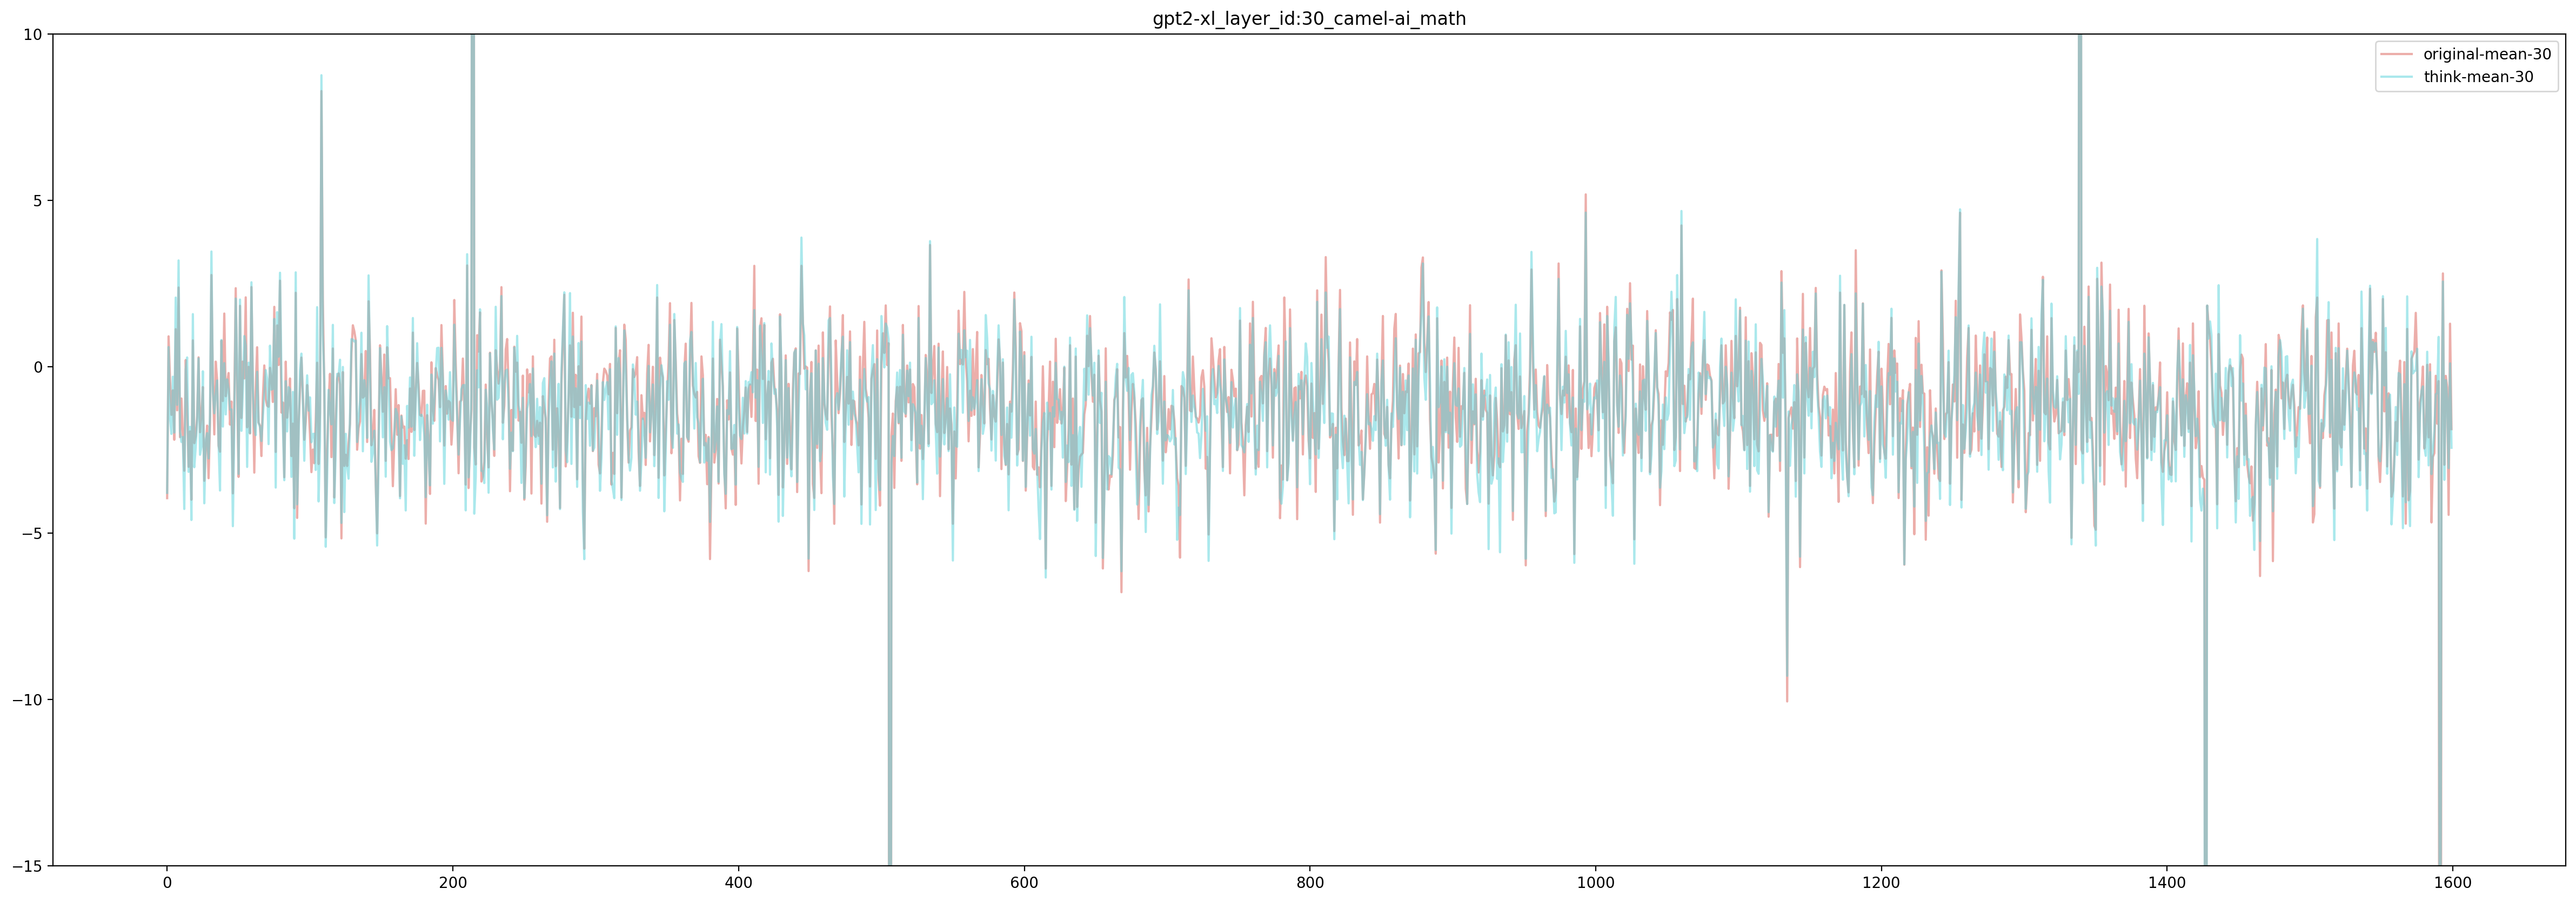

In [31]:
layer_id = 30

title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
data_pd = get_data_pd(d, layer_id)

x = range(unit_num)
mean_pd = data_pd.groupby(['label']).mean()
plot_line(x, mean_pd, datalabel, "mean", layer_id, None, title, dir_path, False)
# print(min_pd)
plot_line(x, mean_pd, datalabel, "mean", layer_id, [-15,10], title, dir_path, False)

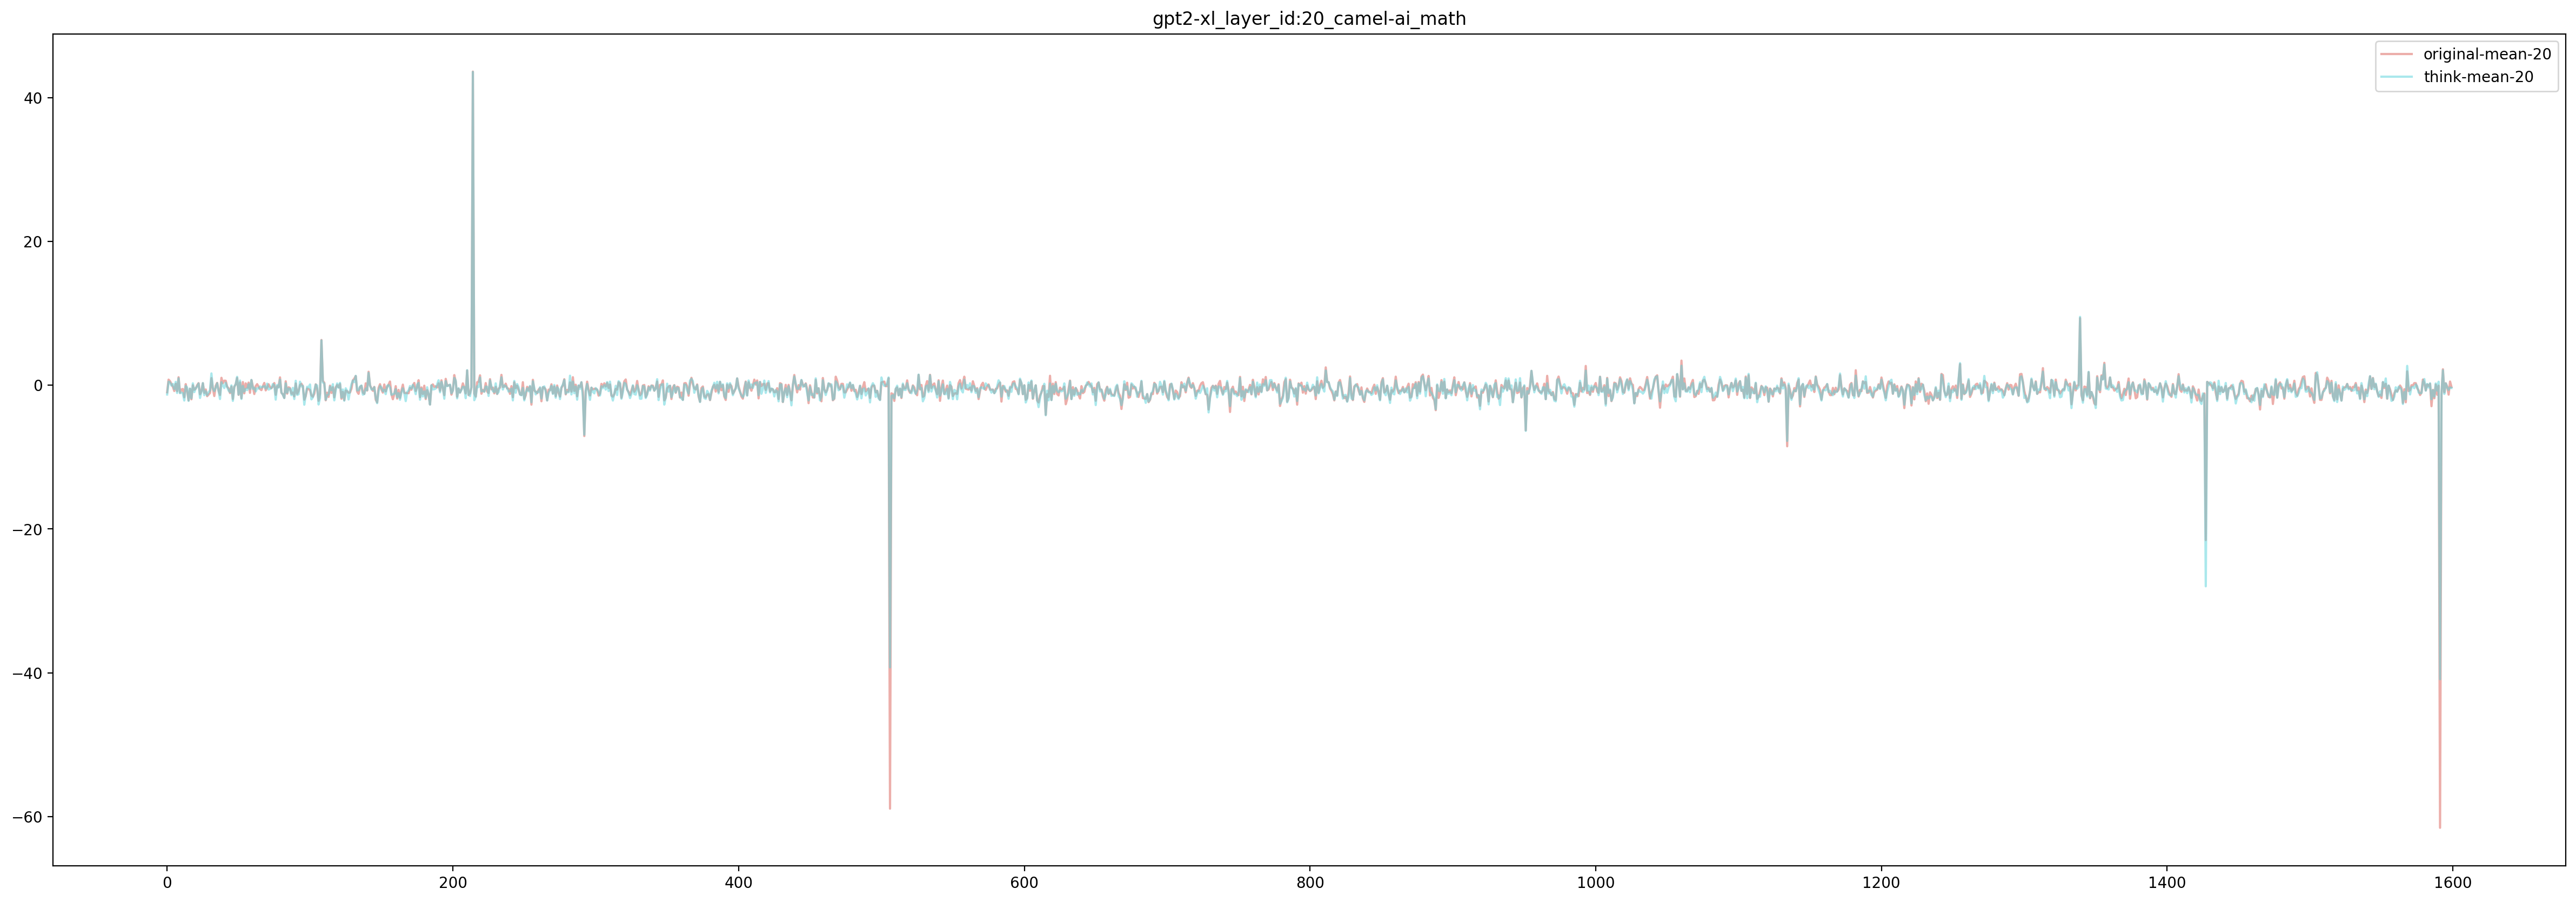

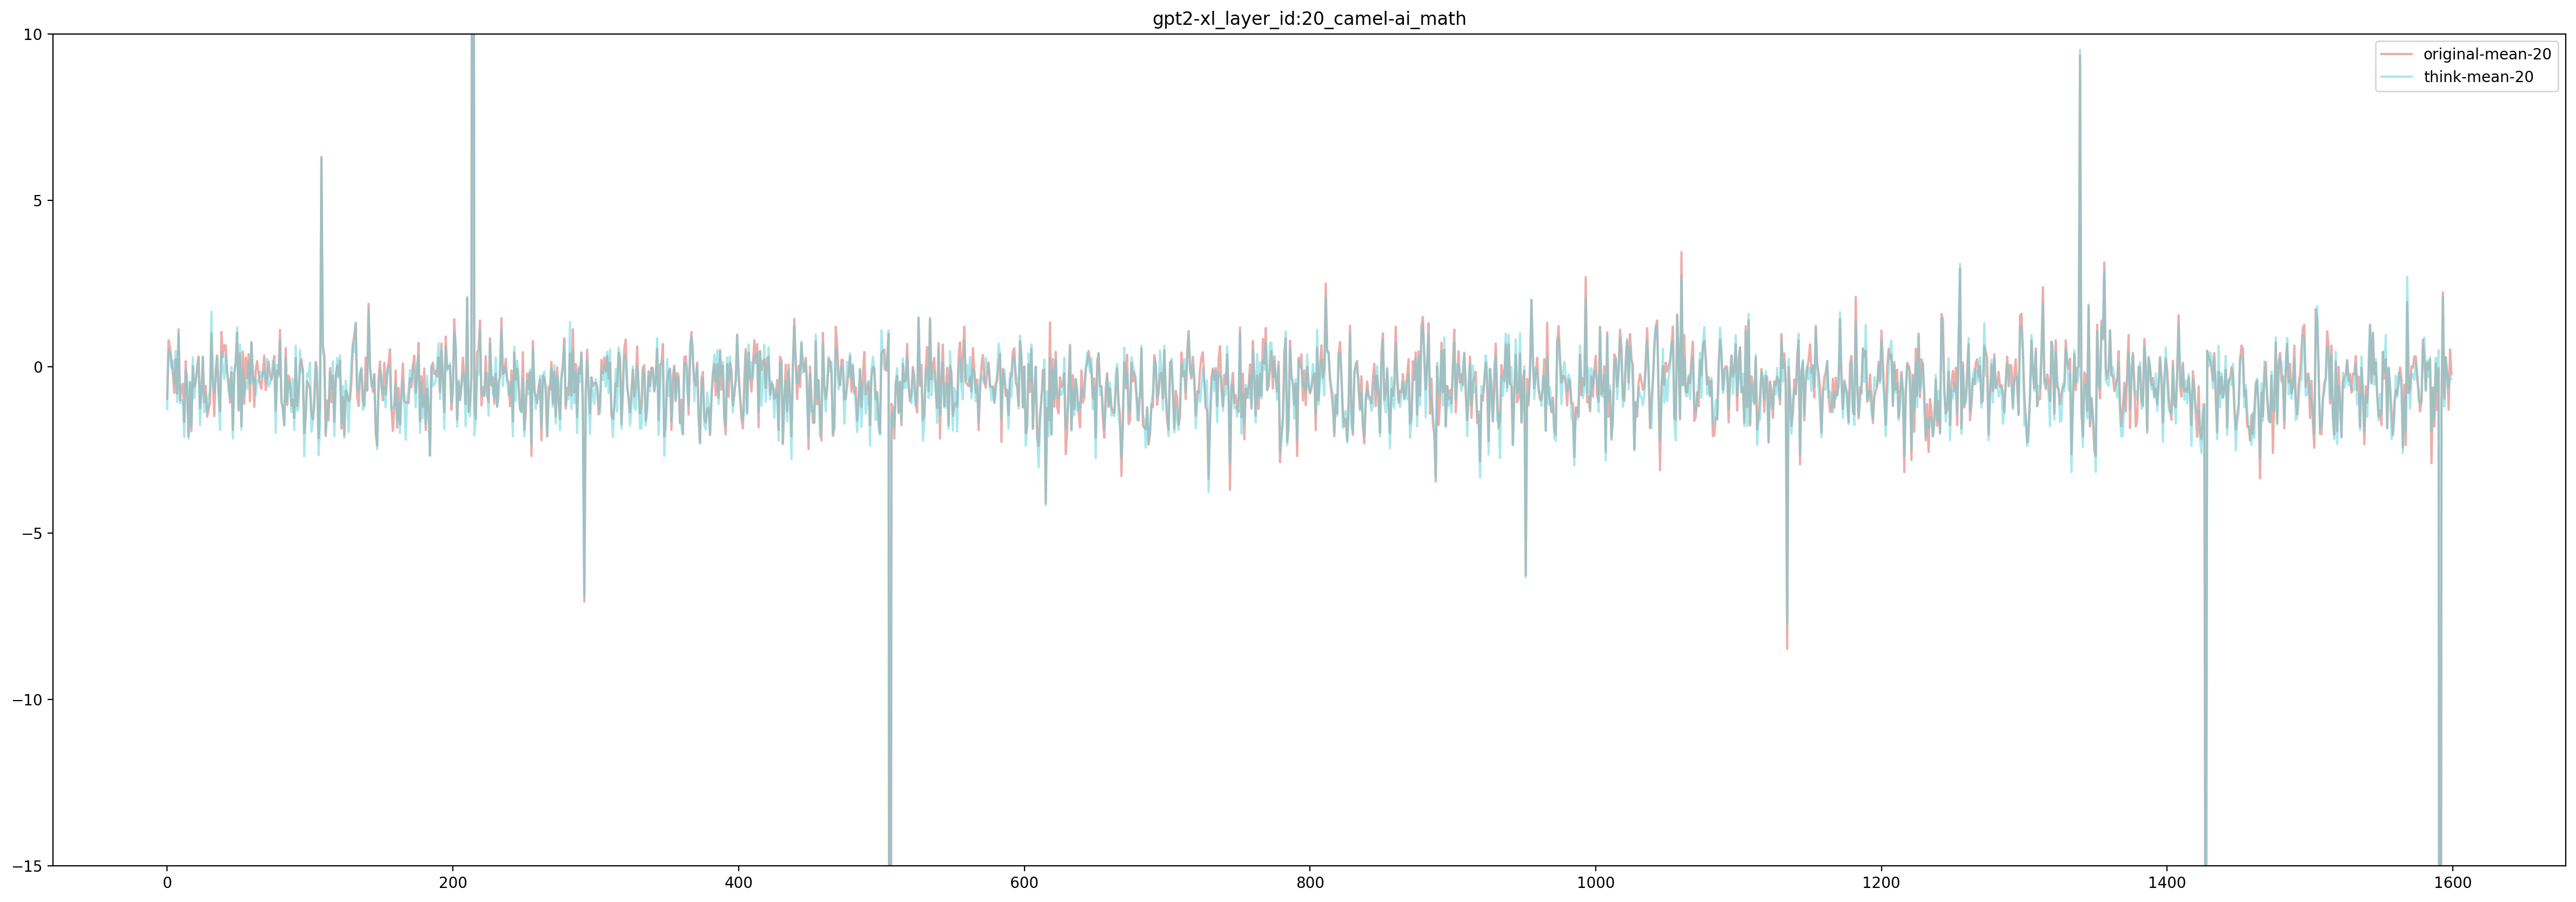

In [32]:
layer_id = 20

title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
data_pd = get_data_pd(d, layer_id)



mean_pd = data_pd.groupby(['label']).mean()
plot_line(x, mean_pd, datalabel, "mean", layer_id, None, title, dir_path, False)
# print(min_pd)
plot_line(x, mean_pd, datalabel, "mean", layer_id, [-15,10], title, dir_path, False)